# Importing the Relevant Libraries

In [1]:
import os  #To load the dataset
import time #To time the training
from sklearn.model_selection import train_test_split    #For splitting the train images into a train and a validation split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix     #Metrics for evaluation
import matplotlib.pyplot as plt     #For plotting the various curves, images etc.

In [2]:
import timm     #To load the model directly from huggingface repository
import torch
from torch import nn    #To allow modifications to the model architecture
from torch import optim #Contains optimizers
from torchsummary import summary

/DATA2/dse313/group10/env_assignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torchvision import transforms      #To transform the dataset into the form the model desires
from torch.utils.data import Dataset, DataLoader    #To load the dataset via the path, we will use the Torch DataLoader and Dataset 
from PIL import Image   #To display the images

# Loading the Dataset

A Class which is a child class of Dataset, used to load the image dataset via DataLoader

In [4]:
class LoadData(Dataset):
    def __init__(self, path, trf_type, isTrain):
        self.path=path
        self.trf_type=trf_type
        self.isTrain=isTrain

        self.labels=['abandoned','commercial','industrial','others','religious','residential','underconstruction']
        self.data=self.load_data()

    #Function to load the path of the data and allocate it to test or train based on its name
    def load_data(self):   
        data=[]
        for label_idx,label in enumerate(self.labels):
            loc=self.path+label+'/'
            type='train' if self.isTrain else 'test'

            for file in os.listdir(loc):
                if file.startswith(type):
                    file_path=loc+file

                    data.append((file_path, label_idx)) 
        
        return data
    def __len__(self):
        return len(self.data)
    
    #Necessary for a DataLoader class, loads the image from the path and applies the suitable transformation
    def __getitem__(self,idx):
        img_path, label= self.data[idx]
        img=Image.open(img_path).convert('RGB')
        img=self.trf_type(img)
        return img, label

The transformations specified for the ResNet-50 model

In [5]:
# Transformations for the training data
trf_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Transformations for the testing data
trf_test=transforms.Compose([
    transforms.Resize((288,288)),
    transforms.ToTensor()
])

Creating, splitting and loading the image dataset into a train, valid and test split. 25% of train data is used for validation

In [6]:
path='/DATA2/dse313/group10/pure/pure/'
train_dataset= LoadData(path, trf_train, True)
test_dataset= LoadData(path, trf_test, False)

In [7]:
train_split, val_split= train_test_split(train_dataset, test_size=0.25, random_state=2)

In [8]:
batch=32 #Batch size 
# train_loader=DataLoader(train_dataset, batch_size=batch, shuffle=True)
train_loader=DataLoader(train_split, batch_size=batch, shuffle=True)
val_loader=DataLoader(val_split,batch_size=batch, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch, shuffle=True)

# Visualizing the Dataset

A count of the different classes in the dataset

In [9]:
def visualize_count(dataset,title):
    print()
    print(f'::::{title}::::')
    print('Total size of the dataset:', len(dataset))
    
    class_labels=dataset.labels
    count=[0]*len(class_labels)
    for img, label in dataset:
        count[label]+=1
    merged=dict(zip(class_labels,count))
    print(merged)


visualize_count(train_dataset, 'Training Dataset')
visualize_count(test_dataset, 'Testing Dataset')


::::Training Dataset::::
Total size of the dataset: 2595
{'abandoned': 85, 'commercial': 626, 'industrial': 199, 'others': 244, 'religious': 94, 'residential': 1207, 'underconstruction': 140}

::::Testing Dataset::::
Total size of the dataset: 391
{'abandoned': 21, 'commercial': 90, 'industrial': 37, 'others': 79, 'religious': 23, 'residential': 106, 'underconstruction': 35}


A Function which displays 15 random images from a dataset

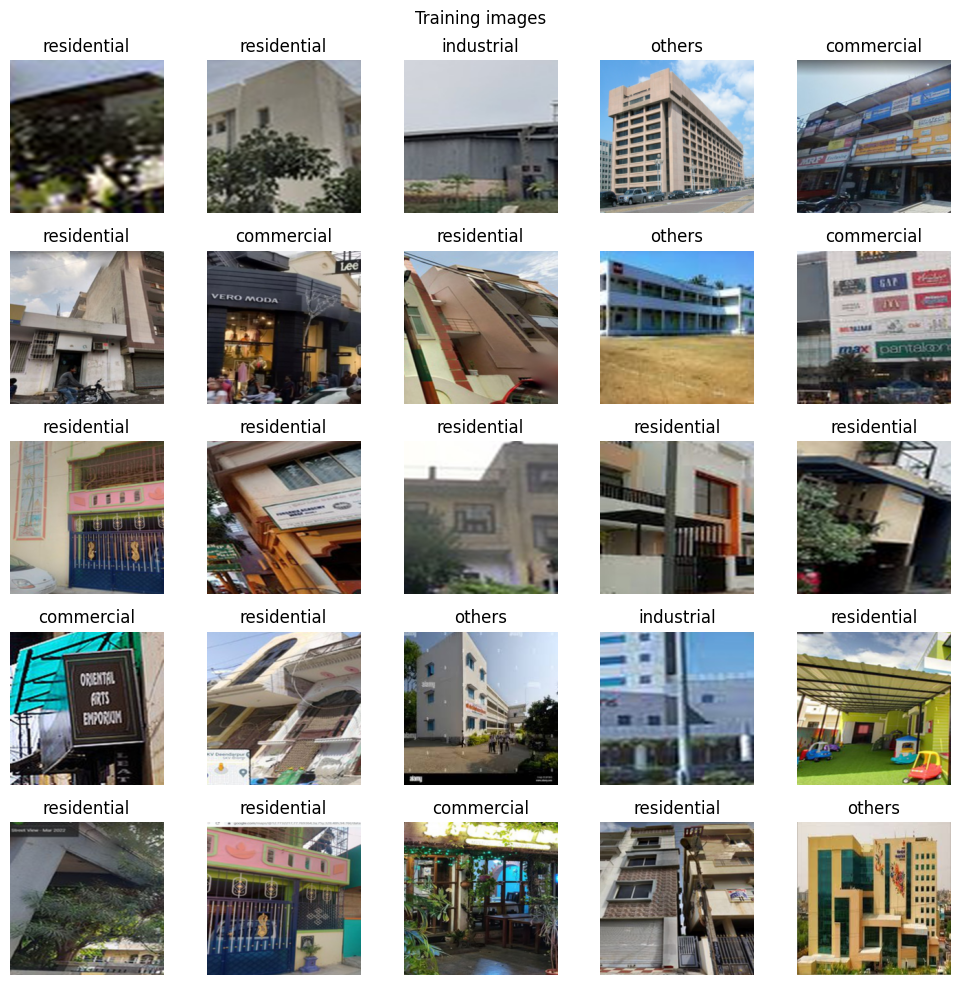

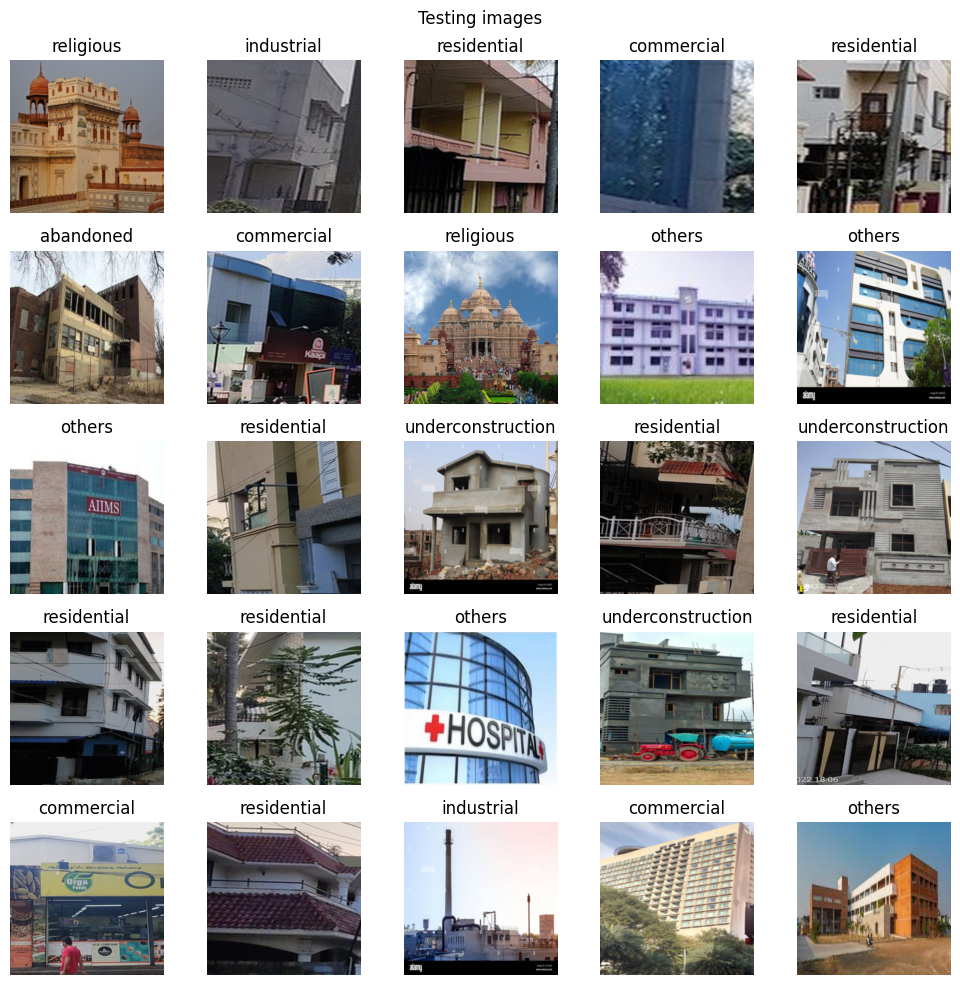

In [10]:
import random
def visualize_samples(dataset,title):
    
    fig, ax= plt.subplots(nrows=5, ncols=5, figsize=[10,10])
    fig.suptitle(title)

    for i,axi in enumerate(ax.flat):
        idx=random.randint(0,len(dataset)-1)
        img, label= dataset[idx]

        axi.imshow(transforms.ToPILImage()(img))
        axi.set_title(dataset.labels[label])
        axi.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset,'Training images')
visualize_samples(test_dataset,'Testing images')

# Training the model

Downloading the pretrained ResNet-50 model from huggingface repository using timm

In [11]:
model=timm.create_model('hf_hub:timm/resnet50.a1_in1k',
                        pretrained= True)

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Freezing the model as we just need to train the final layer

In [13]:
summary(model.cuda(), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
for each_param in model.parameters():
    each_param.requires_grad=False

In [15]:
summary(model.cuda(), input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Shifting to GPU

In [16]:
torch.cuda.empty_cache()

In [17]:
device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:1


Creating a new final layer for the model based on the new number of classes

In [18]:
num_classes=len(train_dataset.labels)
# num_classes= 7
model.fc= nn.Linear(model.fc.in_features,num_classes)

In [19]:
summary(model.cuda(), input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
for idx,param in enumerate(model.parameters()): 
    if param.requires_grad: print(idx)

159
160


In [21]:
device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:1


In [22]:
# Rechecking if last layer is replaced or not
# summary(model, input_size=(3,224,224))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Defining the Hyperparameters

In [23]:
loss_fun=nn.CrossEntropyLoss()
# optimizer=optim.SGD(params=model.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
optimizer= optim.Adam(params=model.parameters(), lr=5e-4)
epochs=25

In [24]:
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]

Training the model

In [25]:
for epoch in range(epochs):
    
    #Training 
    model.train()
    tot_train_loss=0
    train_correct=0
    train_tot=0

    tick= time.time()

    for batch_id, (imgs, labels) in enumerate(train_loader):
        #Sending the data to the device
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        #Fwd Pass
        out=model(imgs)
        loss=loss_fun(out,labels)

        #Bwd Pass
        loss.backward()
        optimizer.step()

        tot_train_loss+=loss.item()*imgs.size(0)

        x,pred=torch.max(out,1)
        train_correct+=(pred==labels).sum().item()
        train_tot+=labels.size(0)

    train_loss= tot_train_loss/len(train_loader.dataset)
    train_acc= train_correct/train_tot
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #Validation
    model.eval()
    tot_val_loss=0
    val_correct=0
    val_tot=0

    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs=val_imgs.to(device)
            val_labels=val_labels.to(device)

            val_out=model(val_imgs)
            vloss= loss_fun(val_out,val_labels)
            tot_val_loss+=vloss.item()*val_imgs.size(0)

            _, val_pred= torch.max(val_out,1)
            val_correct+=(val_pred==val_labels).sum().item()
            val_tot+=val_labels.size(0)

    val_loss= tot_val_loss/len(val_loader.dataset)
    val_acc= val_correct/val_tot
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    tock=time.time()
    tot_time=tock-tick

    print(f'Epoch:{epoch+1}\t Train_Loss: {train_loss:.4f}\t Val_Loss: {val_loss:.4f}\t Train_Acc: {train_acc:.4f}\t Val_Acc: {val_acc:.4f}\t Time: {tot_time:.2f} seconds')

Epoch:1	 Train_Loss: 1.5289	 Val_Loss: 1.4084	 Train_Acc: 0.4573	 Val_Acc: 0.5223	 Time: 3.67 seconds
Epoch:2	 Train_Loss: 1.3482	 Val_Loss: 1.2874	 Train_Acc: 0.5339	 Val_Acc: 0.5794	 Time: 1.65 seconds
Epoch:3	 Train_Loss: 1.2301	 Val_Loss: 1.2162	 Train_Acc: 0.5745	 Val_Acc: 0.5948	 Time: 1.49 seconds
Epoch:4	 Train_Loss: 1.1420	 Val_Loss: 1.1417	 Train_Acc: 0.6064	 Val_Acc: 0.6364	 Time: 1.47 seconds
Epoch:5	 Train_Loss: 1.0743	 Val_Loss: 1.0977	 Train_Acc: 0.6326	 Val_Acc: 0.6394	 Time: 1.48 seconds
Epoch:6	 Train_Loss: 1.0080	 Val_Loss: 1.0569	 Train_Acc: 0.6562	 Val_Acc: 0.6626	 Time: 1.49 seconds
Epoch:7	 Train_Loss: 0.9701	 Val_Loss: 1.0086	 Train_Acc: 0.6629	 Val_Acc: 0.6595	 Time: 1.52 seconds
Epoch:8	 Train_Loss: 0.9205	 Val_Loss: 0.9821	 Train_Acc: 0.6860	 Val_Acc: 0.6672	 Time: 1.62 seconds
Epoch:9	 Train_Loss: 0.8869	 Val_Loss: 0.9547	 Train_Acc: 0.7143	 Val_Acc: 0.6810	 Time: 1.56 seconds
Epoch:10	 Train_Loss: 0.8481	 Val_Loss: 0.9242	 Train_Acc: 0.7081	 Val_Acc: 0.6857

# Evaluating the model

Plotting the Loss and Accuracy Curves

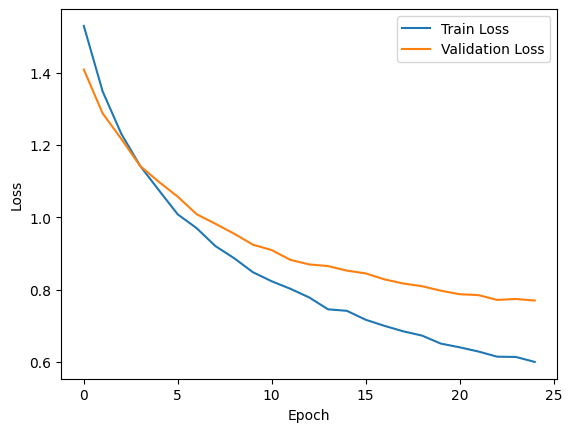

In [26]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

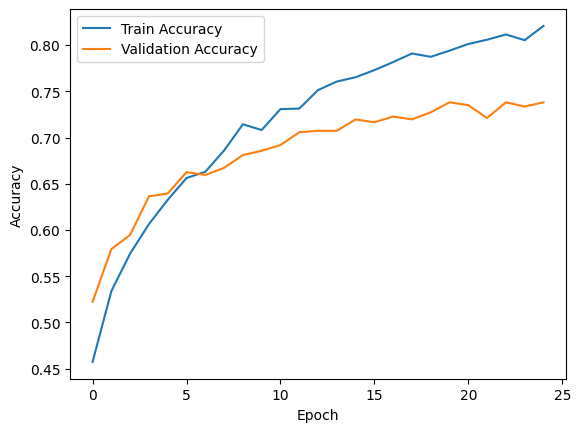

In [27]:
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Function to print the classification report and the confusion matrix for each split

In [28]:
def eval_model(model, data):
    model.eval()
    all_labels=[]
    preds=[]

    with torch.no_grad():
        for imgs, labels in data:
            imgs= imgs.to(device)
            labels=labels.to(device)
            out=model(imgs)
            _, pred= torch.max(out,1)

            all_labels.extend(labels.cpu().numpy())
            preds.extend(pred.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels,preds, target_names=train_dataset.labels))

    print('Confusion Matrix:')
    cm=confusion_matrix(all_labels,preds)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.labels)
    disp.plot()
    plt.tight_layout()
    disp.ax_.set_xticklabels(labels= train_dataset.labels, rotation=90)
    plt.show()



Evaluation on train split

Classification Report:
                   precision    recall  f1-score   support

        abandoned       0.98      0.73      0.84        63
       commercial       0.89      0.76      0.82       480
       industrial       0.89      0.53      0.67       158
           others       0.89      0.87      0.88       175
        religious       0.89      0.94      0.92        70
      residential       0.81      0.96      0.88       893
underconstruction       0.96      0.79      0.87       107

         accuracy                           0.85      1946
        macro avg       0.90      0.80      0.84      1946
     weighted avg       0.86      0.85      0.85      1946

Confusion Matrix:


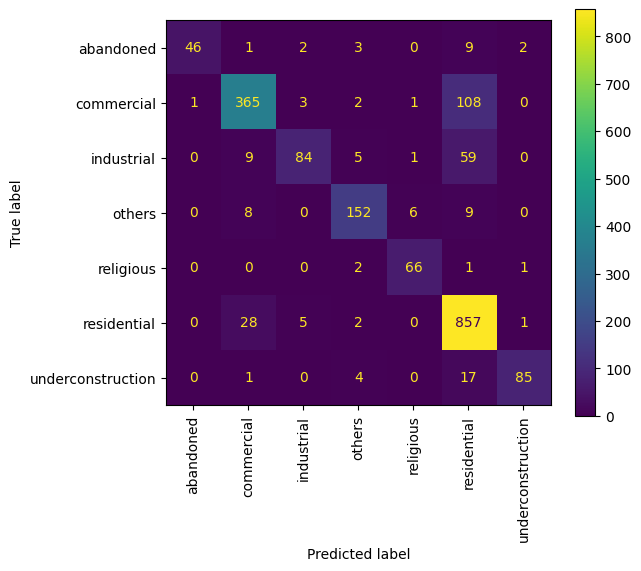

In [29]:
eval_model(model, train_loader)

Evaluation on validation split

Classification Report:
                   precision    recall  f1-score   support

        abandoned       0.75      0.41      0.53        22
       commercial       0.77      0.60      0.67       146
       industrial       0.67      0.39      0.49        41
           others       0.75      0.62      0.68        69
        religious       0.75      0.62      0.68        24
      residential       0.74      0.92      0.82       314
underconstruction       0.68      0.58      0.62        33

         accuracy                           0.74       649
        macro avg       0.73      0.59      0.64       649
     weighted avg       0.74      0.74      0.73       649

Confusion Matrix:


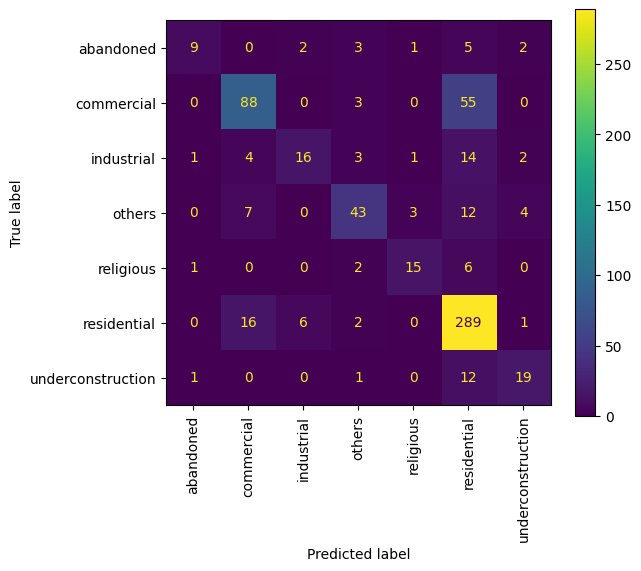

In [30]:
eval_model(model, val_loader)

Evaluation on test split

Classification Report:
                   precision    recall  f1-score   support

        abandoned       0.83      0.24      0.37        21
       commercial       0.68      0.42      0.52        90
       industrial       0.93      0.38      0.54        37
           others       0.82      0.51      0.62        79
        religious       0.88      0.61      0.72        23
      residential       0.42      0.92      0.58       106
underconstruction       0.83      0.43      0.57        35

         accuracy                           0.57       391
        macro avg       0.77      0.50      0.56       391
     weighted avg       0.69      0.57      0.57       391

Confusion Matrix:


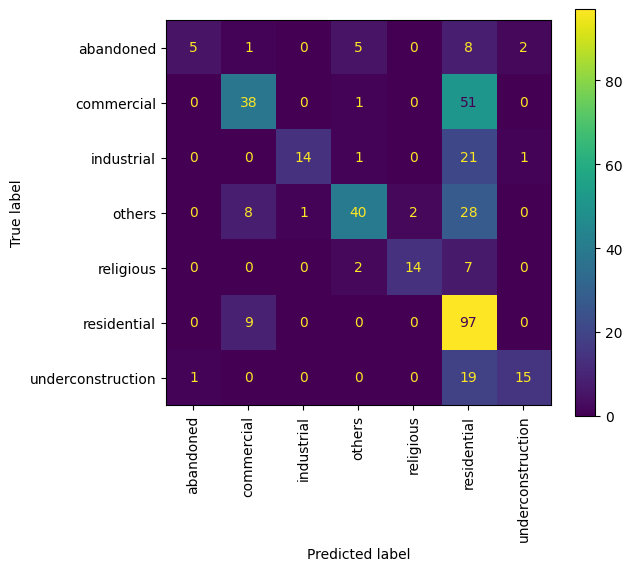

In [31]:
eval_model(model, test_loader)

Evaluating the model based on test images with predicted and actual label

In [32]:
model.eval()
with torch.no_grad():
    imgs, labels= next(iter(test_loader))   #Selecting a batch from the test dataloader 
    imgs= imgs.to(device)
    labels= labels.to(device)
    out=model(imgs)
    x, preds=torch.max(out,1)

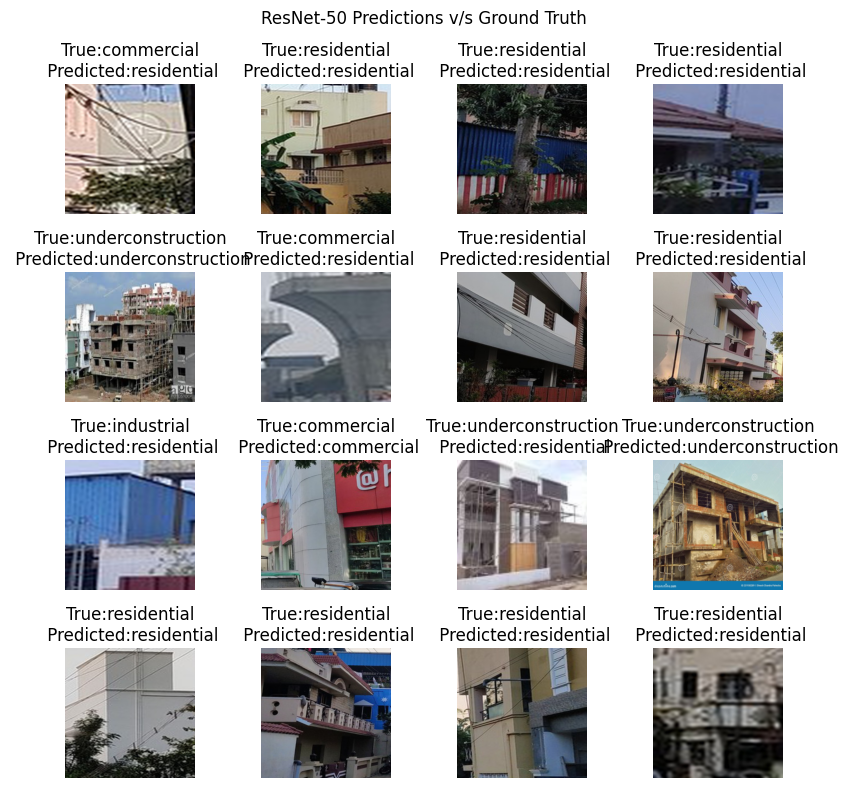

In [33]:
fig, ax= plt.subplots(nrows=4, ncols=4, figsize=[8,8])
all_labels=train_dataset.labels
fig.suptitle('ResNet-50 Predictions v/s Ground Truth')
for i,axi in enumerate(ax.flat):
    img=imgs[i].cpu()
    true_label=labels[i].cpu()
    
    img=transforms.ToPILImage()(img)
    axi.imshow(img)
    axi.set_title(f'True:{all_labels[true_label]}\n Predicted:{all_labels[preds[i]]}')
    axi.axis('off')
plt.tight_layout()
plt.show()
    

# Storing the model and its weights for future

In [34]:
torch.save(model.state_dict(), 'resnet_phase1.pth')

In [37]:
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name,":",param.data)

fc.weight : tensor([[ 0.0479,  0.0720, -0.0124,  ..., -0.0235,  0.0708,  0.0486],
        [ 0.0901,  0.0221,  0.0815,  ...,  0.0207, -0.0729,  0.0254],
        [-0.0774, -0.0231,  0.0829,  ..., -0.0244,  0.0380, -0.0185],
        ...,
        [ 0.1422, -0.0903, -0.1189,  ...,  0.0048, -0.0148,  0.0744],
        [-0.0598, -0.1607, -0.0406,  ..., -0.0371,  0.0083, -0.1597],
        [-0.0211,  0.1338, -0.0733,  ..., -0.0101, -0.1050, -0.0141]],
       device='cuda:1')
fc.bias : tensor([-0.0569,  0.0139, -0.0247, -0.0274, -0.0534,  0.0719, -0.0773],
       device='cuda:1')
